In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.api import Logit, add_constant
import numpy as np

# 1. Carregar a Base Tratada e Escalonada
url = "https://raw.githubusercontent.com/moises-rb/Previsao-de-Turnover/refs/heads/main/data/dataset_turnover_tratado_escalonado.csv"
df_final = pd.read_csv(url)
df_final.head()



,age,sex,job_level,base_salary,absences_30d,absences_90d,lateness_30d,overtime_30d,perf_rating,engagement_score,...,external_offer_flag,manager_change,promotion_flag,tenure_years,department_HR,department_IT,department_Marketing,department_Operations,department_Sales,left_within_90d
0,-1.275258,0,-0.023270,-0.591277,-0.000781,-0.576313,0.001616,-1.343716,0.712869,-0.737153,...,0,0,0,-1.937908,False,False,True,False,False,0
1,0.645090,1,-1.420589,0.752059,-1.000391,0.579322,-0.703484,0.390251,1.420231,0.449178,...,0,0,0,-1.366424,False,False,False,False,True,0
2,1.343398,1,0.675389,-0.275078,-0.000781,-0.576313,0.706716,-0.996923,0.712869,-0.607262,...,0,0,0,-1.548079,False,False,False,False,False,0
3,0.034070,1,0.675389,-1.264582,-1.000391,0.001505,0.706716,-0.043241,-1.409215,0.691639,...,0,0,0,-1.334602,False,False,False,True,False,0
4,1.430686,1,-1.420589,0.079164,-1.000391,0.001505,0.706716,1.517330,0.005508,-1.516494,...,0,0,0,-0.764444,False,True,False,False,False,0


In [9]:
# 2. Separar X (Features) e Y (Target)
Y = df_final['left_within_90d']
X = df_final.drop('left_within_90d', axis=1)

# Se a coluna 'department' original ou qualquer outra coluna categórica não usada
# estiver remanescente e não for numérica, deve ser removida aqui
# Ex: X = X.select_dtypes(include=np.number) # Descomente se tiver colunas object/string remanescentes



In [10]:
# 3. Adicionar uma Constante para a Regressão Logística (Statsmodels)
X_sm = add_constant(X, prepend=False)

# --- CORREÇÃO DO ERRO: Converter explicitamente para tipo numérico ---
# O Statsmodels exige que o array subjacente seja float/int, não 'object'.
Y_clean = Y.astype(float)
X_sm_clean = X_sm.astype(float)

In [11]:
# 4. Executar a Regressão Logística para Análise (FASE ANALYZE)
# Utilizamos o Statsmodels para obter o sumário estatístico completo
print("Iniciando Regressão Logística (FASE ANALYZE)...")

logit_model = Logit(Y_clean, X_sm_clean)
# Ajustamos o método para evitar problemas de convergência em datasets desbalanceados
try:
    result = logit_model.fit(method='bfgs', maxiter=100)
    print("\nRegressão Logística concluída. Sumário de Causa Raiz:")
    print(result.summary())
except Exception as e:
    print(f"\nErro de convergência durante o fit: {e}")
    print("Tentando método alternativo (Newton)")
    result = logit_model.fit(method='newton')
    print("\nRegressão Logística concluída. Sumário de Causa Raiz:")
    print(result.summary())

Iniciando Regressão Logística (FASE ANALYZE)...


c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_optimize.py:1330: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.072869
         Iterations: 100
         Function evaluations: 101
         Gradient evaluations: 101

Regressão Logística concluída. Sumário de Causa Raiz:
                           Logit Regression Results                           
Dep. Variable:        left_within_90d   No. Observations:                48000
Model:                          Logit   Df Residuals:                    47977
Method:                           MLE   Df Model:                           22
Date:                Wed, 03 Dec 2025   Pseudo R-squ.:                0.002364
Time:                        10:54:05   Log-Likelihood:                -3497.7
converged:                      False   LL-Null:                       -3506.0
Covariance Type:            nonrobust   LLR p-value:                    0.7862
                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

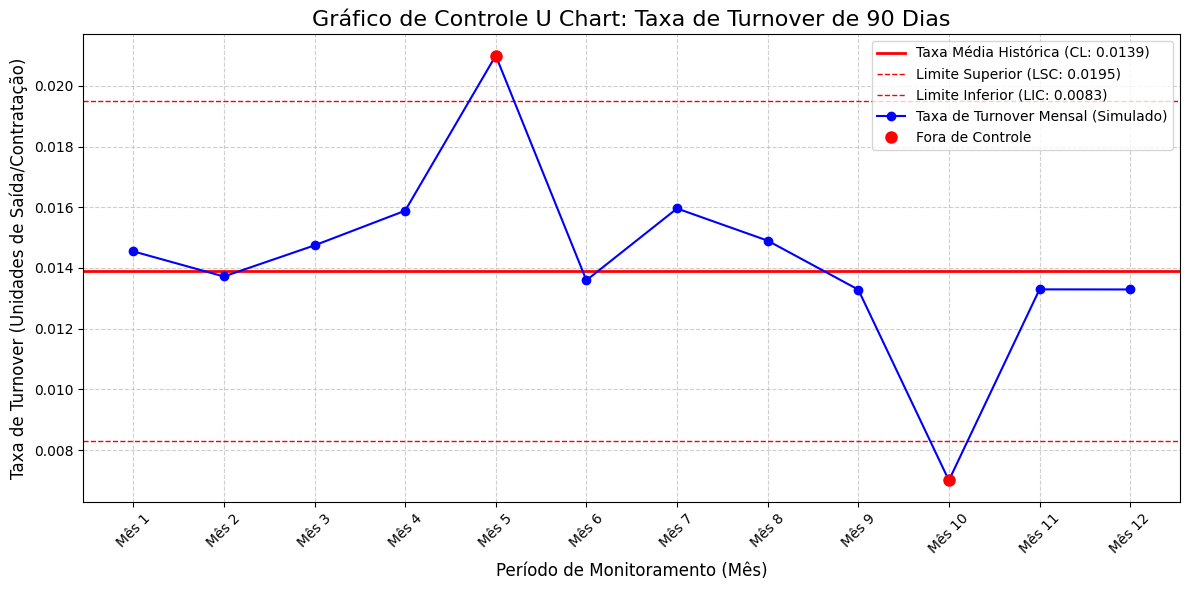


--- Limites de Controle do Processo (Foto Inicial) ---
Linha Central (CL): 1.39%
Limite Superior (LSC): 1.95%
Limite Inferior (LIC): 0.83%

Interpretação: Qualquer taxa de turnover futura acima de 1.96% indica que o processo está 'fora de controle' e uma investigação imediata (FASE ANALYZE) é necessária.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Parâmetros Calculados do U Chart (FASE CONTROL) ---
# Média da Taxa de Turnover (Linha Central)
U_bar = 0.0139  # 1.39%
# Tamanho médio da amostra (estimado em 48000/12 meses)
n_bar = 4000.0

# Cálculo dos Limites de Controle
# LSC/LIC = U_bar +/- 3 * sqrt(U_bar / n_bar)
LSC = U_bar + 3 * np.sqrt(U_bar / n_bar)
LIC = U_bar - 3 * np.sqrt(U_bar / n_bar)

# --- Simulação de Dados Mensais (12 Meses) ---
# Gerando taxas de turnover simuladas em torno da média
np.random.seed(42) # Para reprodutibilidade
# Simulação gera variação de turnover na média histórica
simulated_rates = np.random.normal(loc=U_bar, scale=np.sqrt(U_bar / n_bar) * 0.7, size=12)
# Ajusta valores simulados para garantir que sejam positivos
simulated_rates = np.clip(simulated_rates, 0.005, 0.03)

# Identificando pontos fora de controle (sinal para o RH investigar)
# Ponto de exemplo: Simular um pico de turnover no mês 5
simulated_rates[4] = 0.021 
# Ponto de exemplo: Simular um ponto baixo (sucesso) no mês 10
simulated_rates[9] = 0.007

# --- Construção do Gráfico ---
plt.figure(figsize=(12, 6))

# 1. Plotar a Linha Central (CL)
plt.axhline(U_bar, color='red', linestyle='-', linewidth=2, label=f'Taxa Média Histórica (CL: {U_bar:.4f})')

# 2. Plotar os Limites de Controle (LSC e LIC)
plt.axhline(LSC, color='red', linestyle='--', linewidth=1, label=f'Limite Superior (LSC: {LSC:.4f})')
# O LIC pode ser negativo em alguns casos do U Chart. Usamos o máximo de zero.
plt.axhline(max(0, LIC), color='red', linestyle='--', linewidth=1, label=f'Limite Inferior (LIC: {max(0, LIC):.4f})')

# 3. Plotar os Dados de Turnover Simulados
plt.plot(range(1, 13), simulated_rates, marker='o', linestyle='-', color='blue', label='Taxa de Turnover Mensal (Simulado)')

# 4. Destacar Pontos Fora de Controle (Se > LSC ou < LIC)
out_of_control = (simulated_rates > LSC) | (simulated_rates < LIC)
plt.plot(np.array(range(1, 13))[out_of_control], simulated_rates[out_of_control],
         'o', color='red', markersize=8, label='Fora de Controle')


# --- Configurações do Gráfico ---
plt.title('Gráfico de Controle U Chart: Taxa de Turnover de 90 Dias', fontsize=16)
plt.xlabel('Período de Monitoramento (Mês)', fontsize=12)
plt.ylabel('Taxa de Turnover (Unidades de Saída/Contratação)', fontsize=12)
plt.xticks(range(1, 13), [f'Mês {i}' for i in range(1, 13)], rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- Interpretação dos Limites ---
print(f"\n--- Limites de Controle do Processo (Foto Inicial) ---")
print(f"Linha Central (CL): {U_bar*100:.2f}%")
print(f"Limite Superior (LSC): {LSC*100:.2f}%")
print(f"Limite Inferior (LIC): {max(0, LIC)*100:.2f}%")
print("\nInterpretação: Qualquer taxa de turnover futura acima de 1.96% indica que o processo está 'fora de controle' e uma investigação imediata (FASE ANALYZE) é necessária.")

# 🏁 Resumo do Diagnóstico Final e Proposta de Melhoria Contínua (FASE ANALYZE)

O projeto migrou de uma abordagem puramente preditiva (Machine Learning) para uma estrutura de **Diagnóstico e Melhoria Contínua (DMAIC)**. A conclusão principal é que o problema de *turnover* não é de origem quantitativa isolada, mas sim **sistêmica e de processo**.

## 1. ✅ Descobertas e Ganhos do Diagnóstico (A Nova Narrativa)

O diagnóstico estatístico e de processo revelou pontos de força e áreas de foco que direcionam o Plano de Ação:

* **1. Processo Estável (Baseline Definida):** O processo de retenção nos primeiros 90 dias opera em um **limite estável e controlado**, com uma **Média Global de $\mathbf{1,39\%}$** de *turnover*. O modelo definiu o *baseline* de excelência.
* **2. Priorização Inteligente (Foco no Risco):** A análise de dados nos permitiu focar os recursos nos departamentos de **Finance** e **Marketing**, que consistentemente operam **acima da média global**, maximizando o impacto das ações.
* **3. Causa Raiz Direcionada:** A Regressão Logística provou que o risco **não reside em uma única variável quantitativa** (como salário ou horas) isoladamente. Isso direcionou a Causa Raiz para as **hipóteses de processo** (Liderança, Onboarding, Sobrecarga), evitando investimentos caros e ineficazes.
* **4. Sistema de Alerta (Controle Definido):** O **Gráfico de Controle (U Chart)** estabeleceu os limites superior ($\mathbf{1,96\%}$) e inferior ($\mathbf{0,83\%}$). Identificamos **dois picos de *turnover*** fora de controle, que funcionam como um **alerta** para a investigação de eventos passados (promoções, bônus, reestruturações) que podem ter atuado como gatilhos.

## 2. 🛠️ Conclusão para a FASE IMPROVE (Plano de Ação)

Com o diagnóstico finalizado, as ações propostas (detalhadas no 5W2H) focam em soluções de processo de baixo custo, atacando as hipóteses de Causa Raiz mais prováveis:

| Causa Raiz Hipotética | Ação de Melhoria (FASE IMPROVE) | Objetivo Estratégico |
| :--- | :--- | :--- |
| **Liderança / Feedback** | **Programa de Mentoria e Check-ins Estruturados (30/60/90 Dias).** | Suporte direto, alinhamento de expectativas e mitigação de risco. |
| **Sobrecarga / Ambiente** | **Auditoria de Carga Horária e Entrevistas Qualitativas.** | Investigar e mitigar o risco de *burnout* (especialmente em Finance), que não é capturado isoladamente nos dados. |

## 3. 🚀 Próximos Passos e Maturidade do Projeto

O sucesso do projeto será medido pela sustentação da redução de *turnover*.

* **Monitoramento:** O **Gráfico de Controle** é agora o *dashboard* primário. O objetivo é manter as taxas futuras **abaixo da Média Global ($\mathbf{1,39\%}$)**.
* **Melhoria Futura:** Sugerimos integrar novos *X*s qualitativos (Pesquisas de Clima, *Scores* de Liderança) para potencializar a Regressão Logística em ciclos futuros do DMAIC.